### Vighnesh Mane (210021607) - PG

In [ ]:
# Google Colab Setup (reference: Lab 07)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# recall the path in Google Drive (reference: Lab 07)
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', '.DS_Store', 'Video', 'Code', 'Models', 'svm_sift.pkl', 'test_functions.ipynb']


In [ ]:
GOOGLE_DRIVE_PATH

'drive/My Drive/CW_Folder_PG'

In [ ]:
# update opencv (reference: Lab 07)
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# check correct opencv version (reference: Lab 07)
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


In [ ]:
# copy and unzip dataset directly on the Colab server (reference: Lab 07)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
# import libraries
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
%matplotlib inline

In [ ]:
# import data from the respective directories (reference : Lab 07)
# Here we have not considered labels_list = None
def loading_im_lab_data(path):
  # getting image files from the directories
  folder_images = [folder for folder in sorted(os.listdir(path)) if folder.endswith('.jpg')]
  images = [cv2.imread(os.path.join(path, folder)) for folder in folder_images]
  # getting label files from the directories
  folder_labels = open("labels/list_label_" + path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in folder_labels]
  return images, labels
X_train, y_train = loading_im_lab_data("train")
X_test, y_test = loading_im_lab_data("test")

In [ ]:
# (reference: https://www.w3schools.com/python/ref_func_len.asp#:~:text=The%20len()%20function%20returns,of%20characters%20in%20the%20string.)
# checking the length of the training data and testing data
print(len(y_train))
print(len(y_test))

12271
3068


In [ ]:
# (reference : Lab 07)
print(Counter(y_train))
print(Counter(y_test))

Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})
Counter({'4': 1185, '7': 680, '5': 478, '1': 329, '6': 162, '3': 160, '2': 74})


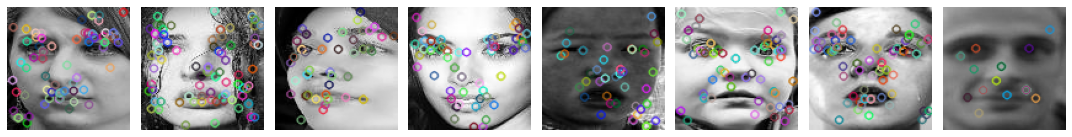

In [ ]:
# (reference: Lab 07)
# Initiate SIFT detector
sift_detect = cv2.SIFT_create()


fig, ax = plt.subplots(1, 8, figsize=(15, 8), sharey=True)
# Create empty lists for feature descriptors and labels.
descriptors_list = []
y_train_list = []

# For loop extracts a collection of feature descriptors from each image in the training batch by locating interest points
for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    keypoints, descriptors = sift_detect.detectAndCompute(img, None)

    # Show results for first 8 images
    if i<8:
        SIFT_img = cv2.drawKeypoints(img, keypoints, img)
        ax[i].imshow(SIFT_img)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if descriptors is not None:
        descriptors_list.append(descriptors)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
descriptors_array = np.vstack(descriptors_list)

In [ ]:
# (reference: Lab 07)
# Number of centroids/codewords: good rule of thumb is 10*num_classes
clusters_k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
b_size = descriptors_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=clusters_k, batch_size=b_size).fit(descriptors_array)

In [ ]:
# (reference: Lab 07)
# Convert descriptors into histograms of codewords for each image
hist_list = []
index_list = []

for descriptors in descriptors_list:
    hist = np.zeros(clusters_k)

    idx = kmeans.predict(descriptors)
    index_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(descriptors))
    hist_list.append(hist)

hist_array1 = np.vstack(hist_list)

In [ ]:
# (reference : Lab 07)
# Create a classifier: Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
class_mlp_sift = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

In [ ]:
# (reference: Lab 07)

hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    keypoints, descriptors = sift_detect.detectAndCompute(img, None)

    if descriptors is not None:
        hist = np.zeros(clusters_k)

        idx = kmeans.predict(descriptors)

        for j in idx:
            hist[j] = hist[j] + (1 / len(descriptors))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
index_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in index_not_empty]
y_test = [y_test[i] for i in index_not_empty]
hist_array2 = np.vstack(hist_list)

In [ ]:
# fitting the mlp classifier
class_mlp_sift.fit(hist_array1,y_train_list)

Iteration 1, loss = 1.66063542
Iteration 2, loss = 1.63939547
Iteration 3, loss = 1.63583484
Iteration 4, loss = 1.63183305
Iteration 5, loss = 1.62638247
Iteration 6, loss = 1.62023138
Iteration 7, loss = 1.61390564
Iteration 8, loss = 1.60641268
Iteration 9, loss = 1.60158814
Iteration 10, loss = 1.59641041
Iteration 11, loss = 1.59254582
Iteration 12, loss = 1.59039585
Iteration 13, loss = 1.58754225
Iteration 14, loss = 1.58438688
Iteration 15, loss = 1.58047629
Iteration 16, loss = 1.57679115
Iteration 17, loss = 1.57548802
Iteration 18, loss = 1.57317052
Iteration 19, loss = 1.56939819
Iteration 20, loss = 1.56764875
Iteration 21, loss = 1.56464571
Iteration 22, loss = 1.56365030
Iteration 23, loss = 1.56209438
Iteration 24, loss = 1.55803274
Iteration 25, loss = 1.55673530
Iteration 26, loss = 1.55532902
Iteration 27, loss = 1.55326348
Iteration 28, loss = 1.55037716
Iteration 29, loss = 1.55001357
Iteration 30, loss = 1.54865514
Iteration 31, loss = 1.54737695
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

In [ ]:
# predciting the mlp classifier
class_mlp_sift_predict = class_mlp_sift.predict(hist_array2).tolist()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_mlp_sift}:
      {metrics.classification_report(y_test, class_mlp_sift_predict)}\n""")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):
                    precision    recall  f1-score   support

           1       0.41      0.09      0.15       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.44      0.89      0.58      1183
           5       0.31      0.15      0.20       478
           6       0.00      0.00      0.00       161
           7       0.41      0.22      0.29       680

    accuracy                           0.42      3065
   macro avg       0.23      0.19      0.17      3065
weighted avg       0.35      0.42      0.34      3065




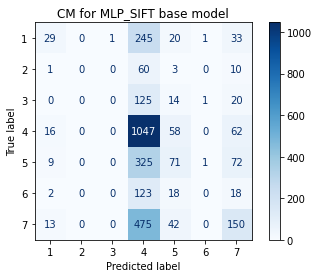

In [ ]:
# (reference : Lab 07)
# confusion matrix for base mlp_sift model
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_mlp_sift_predict,cmap=plt.cm.Blues)
plt.title('CM for MLP_SIFT base model')
plt.show()

In [ ]:
# (reference : https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa)
from sklearn.model_selection import GridSearchCV
mlp_parameters = {'activation': ['tanh', 'relu'],'solver': ['sgd', 'adam'],'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}
class_mlp_sift_para = GridSearchCV(MLPClassifier(random_state=1, max_iter=200, hidden_layer_sizes=(3,3), alpha=1e-5), mlp_parameters, n_jobs=-1, cv=3)
class_mlp_sift_para.fit(hist_array1, y_train_list)

GridSearchCV(cv=3,
             estimator=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 3),
                                     random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
print(class_mlp_sift_para.best_params_)
print(class_mlp_sift_para.best_estimator_)

{'activation': 'tanh', 'alpha': 0.05, 'learning_rate': 'constant', 'solver': 'adam'}
MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(3, 3),
              random_state=1)


In [ ]:
# (reference: Lab 07)
# create mlp model with best hyperparameters obtained from grid search
# Create a classifier: a support vector classifier with best hyperparameters
class_mlp_sift_best_para = MLPClassifier(hidden_layer_sizes=(3,3), max_iter=100, alpha=0.05,
                    solver='adam', verbose=True, random_state=1,
                    learning_rate = 'constant',activation = 'tanh')
class_mlp_sift_best_para.fit(hist_array1, y_train_list)

Iteration 1, loss = 2.05957899
Iteration 2, loss = 1.91326325
Iteration 3, loss = 1.81508140
Iteration 4, loss = 1.74782101
Iteration 5, loss = 1.70122839
Iteration 6, loss = 1.67176084
Iteration 7, loss = 1.65603054
Iteration 8, loss = 1.64894405
Iteration 9, loss = 1.64578111
Iteration 10, loss = 1.64439175
Iteration 11, loss = 1.64357649
Iteration 12, loss = 1.64318947
Iteration 13, loss = 1.64277993
Iteration 14, loss = 1.64247265
Iteration 15, loss = 1.64221479
Iteration 16, loss = 1.64189397
Iteration 17, loss = 1.64155717
Iteration 18, loss = 1.64128682
Iteration 19, loss = 1.64083693
Iteration 20, loss = 1.64045699
Iteration 21, loss = 1.64007382
Iteration 22, loss = 1.63962677
Iteration 23, loss = 1.63920639
Iteration 24, loss = 1.63870251
Iteration 25, loss = 1.63813051
Iteration 26, loss = 1.63759819
Iteration 27, loss = 1.63703917
Iteration 28, loss = 1.63634322
Iteration 29, loss = 1.63571284
Iteration 30, loss = 1.63511326
Iteration 31, loss = 1.63433607
Iteration 32, los

MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(3, 3),
              max_iter=100, random_state=1, verbose=True)

In [ ]:
# predciting the mlp classifier
class_mlp_sift_best_predict = class_mlp_sift_best_para.predict(hist_array2).tolist()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_mlp_sift_best_para}:
      {metrics.classification_report(y_test, class_mlp_sift_best_predict)}\n""")

Classification report for classifier MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(3, 3),
              max_iter=100, random_state=1, verbose=True):
                    precision    recall  f1-score   support

           1       0.41      0.03      0.05       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.43      0.87      0.58      1183
           5       0.29      0.05      0.08       478
           6       0.00      0.00      0.00       161
           7       0.32      0.28      0.30       680

    accuracy                           0.41      3065
   macro avg       0.21      0.17      0.14      3065
weighted avg       0.33      0.41      0.31      3065




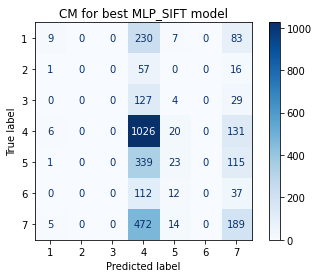

In [ ]:
# (reference : Lab 07)
# confusion matrix for best mlp_sift model
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_mlp_sift_best_predict,cmap=plt.cm.Blues)
plt.title('CM for best MLP_SIFT model')
plt.show()

In [ ]:
# (reference : Lab 07)
from joblib import dump, load
dump(class_mlp_sift_best_para, 'mlp_sift.joblib')

['mlp_sift.joblib']

In [ ]:
class_mlp_sift_best_para = load("mlp_sift.joblib")